# Libs and pre-definitions

In [1]:
import matplotlib.pyplot as plt
import torch
import botorch
import gpytorch
from sklearn.metrics import mean_squared_error

In [2]:
dev = torch.device('cuda')

In [3]:
torch.manual_seed(42);
torch.set_default_dtype(torch.float32)

In [4]:
from math import sqrt
def olivers_fn(X:torch.tensor,x,w:float = 5,gamma:float = 0.3,noise = 0.1):
    y = torch.prod(torch.sin(w*(X))*(1-torch.tanh(gamma*((X)**2))),-1,keepdims=True)
    if noise:
        y += torch.rand_like(y)*sqrt(noise)
    return y

In [5]:
from typing import Any


def uniform_sample(shape,bounds,device = 'cpu'):
    return (bounds[0]-bounds[1])*torch.rand(shape,device=device)+bounds[1]

    
class ThreeHump():
    def __init__(self,noise:float = 0) -> None:
        self.noise = noise
    def __call__(self,phi:torch.tensor, x:torch.tensor = None):
        y = 2*(phi[:, 0].pow(2)) - 1.05*(phi[:, 0]**4) + phi[:, 0] ** 6 / 6 + phi[:,0] * phi[:,1] + phi[:, 1] ** 2
        y = y.view(-1,1)
        if self.noise:
            y += x
        return y
    def sample_x(self,phi,*args):
        return torch.randn((phi.shape[0],1),device = phi.device)*self.noise

class stochastic_ThreeHump(ThreeHump):
    def __init__(self, n_samples = 1, average_x = False,bounds_1 = (-2,0), bounds_2 = (2,5)) -> None:
        super().__init__(0)
        self.bounds_1 = bounds_1
        self.bounds_2 = bounds_2
        self.n_samples = n_samples
        self.average_x = average_x
        self.std = 0.0
    @staticmethod
    def dif_sigma(x):
        return torch.sigmoid(x-10)-torch.sigmoid(x)
    def sample_x(self,phi,n_samples = 1):
        P1 = phi[:,0].div(phi.norm(p=2,dim=-1)).view(-1,1)
        mask = torch.rand((phi.size(0),n_samples),device=phi.device).le(P1)
        x1 = uniform_sample((phi.size(0),n_samples),self.bounds_1,device=phi.device)
        x2 = uniform_sample((phi.size(0),n_samples),self.bounds_2,device=phi.device)
        return torch.where(mask, x1, x2)
    def __call__(self, phi:torch.tensor, x:torch.tensor = None):
        h = super().__call__(phi)
        if x is None: x = self.sample_x(phi,self.n_samples)
        mu = x*h + torch.randn_like(h)*self.std
        y =  mu+torch.randn_like(h)*self.std
        y = self.dif_sigma(y)
        if self.average_x: y = y.mean(-1,keepdim=True)
        return y
    
class RosenbrockProblem():
    def __init__(self,noise:float = 0.1) -> None:
        self.noise = noise
    def __call__(self,phi:torch.tensor,x:torch.tensor = None):
        y =  (phi[:, 1:] - phi[:, :-1].pow(2)).pow(2).sum(dim=1,
                                                        keepdim=True) + (1 - phi[:, :-1]).pow(2).sum(dim=1, keepdim=True)
        if self.noise:
            y += x
        return y
    def sample_x(self,phi,*args):
        return torch.randn((phi.shape[0],1),device = phi.device)*self.noise
    
    
class stochastic_RosenbrockProblem(RosenbrockProblem):
    def __init__(self,bounds = (-10,10), n_samples = 1, average_x = False) -> None:
        super().__init__(0)
        self.bounds = bounds
        self.n_samples = n_samples
        self.average_x = average_x
    def sample_x(self,phi, n_samples=1):
        mu = uniform_sample((phi.shape[0],n_samples),self.bounds,device = phi.device)
        return torch.randn_like(mu)+mu
    def __call__(self,phi:torch.tensor, x:torch.tensor = None):
        if x is None: x = self.sample_x(phi,self.n_samples)
        y = super().__call__(phi) + x
        y += torch.randn(y.size(0),1,device=phi.device)
        if self.average_x: y = y.mean(-1,keepdim = True)
        return y

# Gaussian Process

In [6]:
dimensions_phi = 10
n_samples_x = 100
N_train = N = 101
N_test = N_train
phi_sample = torch.rand(N_train,dimensions_phi,device=dev)
phi_sample_test = torch.rand(N_test,dimensions_phi,device=dev)

problem_fn = stochastic_ThreeHump
problem = problem_fn()

x = problem.sample_x(phi_sample,n_samples_x).view(N_train,-1)
x_test = problem.sample_x(phi_sample_test,n_samples_x).view(N_test,-1)#problem.sample_x(phi_sample_test,n_samples_x).view(N,-1)

y_sample = problem(phi_sample,x)
mean = y_sample.mean(0,keepdim=True)
std = y_sample.std(0,keepdim=True)
y_sample = (y_sample-mean)/std

y_sample_test = problem(phi_sample_test,x_test)
y_sample_test = ((y_sample_test-mean)/std).cpu()

## Concatenate phi and X

In [7]:
gpr_1 = botorch.models.SingleTaskGP(torch.cat([phi_sample.repeat(1,n_samples_x).view(-1,dimensions_phi),x.view(-1,1)],dim=-1),y_sample.view(-1,1)).to(dev)
mll_1 = gpytorch.mlls.ExactMarginalLogLikelihood(gpr_1.likelihood, gpr_1).to(dev)
botorch.fit.fit_gpytorch_mll(mll_1);

/tmp/ipykernel_66489/1470264553.py:1: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gpr_1 = botorch.models.SingleTaskGP(torch.cat([phi_sample.repeat(1,n_samples_x).view(-1,dimensions_phi),x.view(-1,1)],dim=-1),y_sample.view(-1,1)).to(dev)
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., ad

In [8]:
with torch.no_grad():
    observed_pred = gpr_1.posterior(torch.cat([phi_sample_test.repeat(1,n_samples_x).view(-1,dimensions_phi),x_test.view(-1,1)],dim=-1))
y_pred = observed_pred.mean.cpu()
std_pred = observed_pred.mvn.covariance_matrix.diag().sqrt().cpu()

torch.Size([10100, 1])


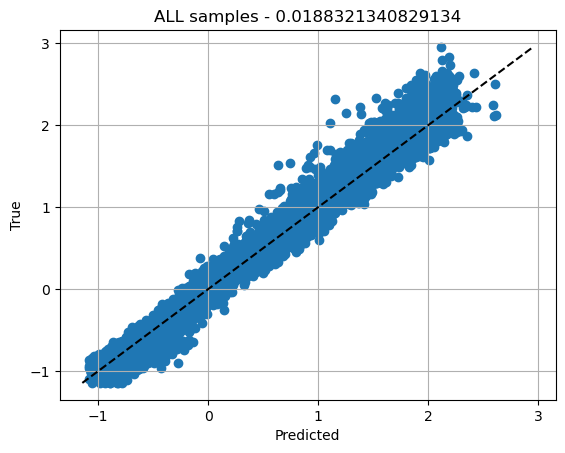

In [9]:
print(y_pred.shape)
plt.scatter(y_pred.view(-1),y_sample_test.view(-1).cpu())
plt.title(f'ALL samples - {mean_squared_error(y_pred.view(-1),y_sample_test.view(-1).cpu())}')
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot([y_sample_test.min(),y_sample_test.max()],[y_sample_test.min(),y_sample_test.max()],'k--')
plt.show()

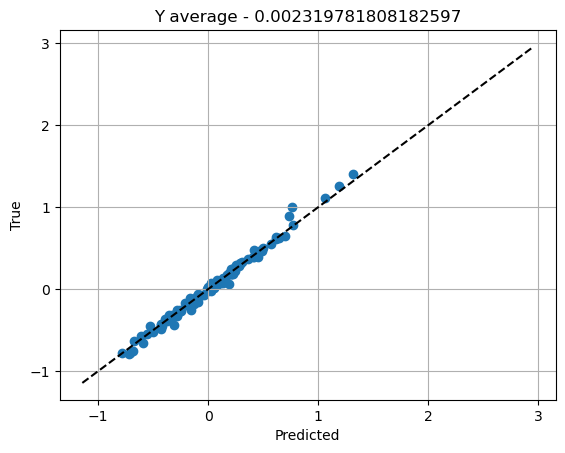

In [10]:
plt.scatter(y_pred.view(N,-1).mean(-1),y_sample_test.mean(-1).cpu())
plt.title(f'Y average - {mean_squared_error(y_pred.view(N,-1).mean(-1),y_sample_test.mean(-1).cpu())}')
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot([y_sample_test.min(),y_sample_test.max()],[y_sample_test.min(),y_sample_test.max()],'k--')
plt.show()

## Take average over X

In [11]:
gpr_2 = botorch.models.SingleTaskGP(phi_sample,y_sample.mean(-1,keepdim = True)).to(dev)
mll_2 = gpytorch.mlls.ExactMarginalLogLikelihood(gpr_2.likelihood, gpr_2).to(dev)
botorch.fit.fit_gpytorch_mll(mll_2);


/tmp/ipykernel_66489/3334835625.py:1: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gpr_2 = botorch.models.SingleTaskGP(phi_sample,y_sample.mean(-1,keepdim = True)).to(dev)
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.3950], device='cuda:0'), mean = tensor([-4.1900e-08], device='cuda:0')). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


In [12]:
with torch.no_grad():
    # Make predictions
    observed_pred = gpr_2.posterior(phi_sample_test)

# Extract mean and standard deviation
y_pred = observed_pred.mean.cpu()
std_pred = observed_pred.mvn.covariance_matrix.diag().sqrt().cpu()

torch.Size([101, 1])


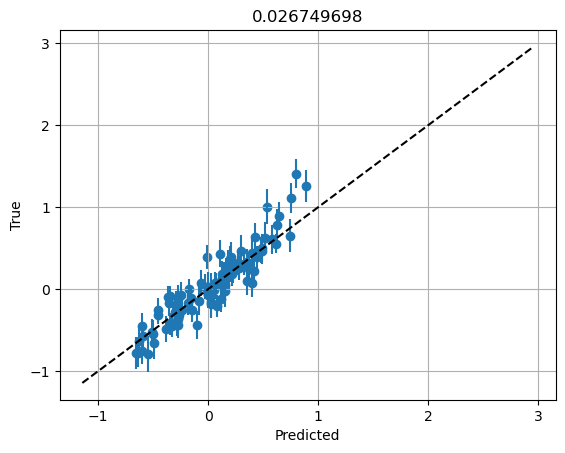

In [13]:
print(y_pred.shape)
plt.scatter(y_pred,y_sample_test.mean(-1).cpu())
plt.errorbar(y_pred,y_sample_test.mean(-1).cpu(),yerr = std_pred,fmt = 'none')
plt.title(mean_squared_error(y_pred.view(-1),y_sample_test.mean(-1).cpu()))
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot([y_sample_test.min(),y_sample_test.max()],[y_sample_test.min(),y_sample_test.max()],'k--')
plt.show()

## No average, not considering x

In [14]:
gpr_3 = botorch.models.SingleTaskGP(phi_sample.repeat(1,n_samples_x).view(-1,dimensions_phi),y_sample.view(-1,1)).to(dev)
mll_3 = gpytorch.mlls.ExactMarginalLogLikelihood(gpr_3.likelihood, gpr_3).to(dev)
botorch.fit.fit_gpytorch_mll(mll_3);

with torch.no_grad():
    observed_pred = gpr_3.posterior(phi_sample_test.repeat(1,n_samples_x).view(-1,dimensions_phi))
y_pred = observed_pred.mean.cpu()
std_pred = observed_pred.mvn.covariance_matrix.diag().sqrt().cpu()

/tmp/ipykernel_66489/2297179202.py:1: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gpr_3 = botorch.models.SingleTaskGP(phi_sample.repeat(1,n_samples_x).view(-1,dimensions_phi),y_sample.view(-1,1)).to(dev)


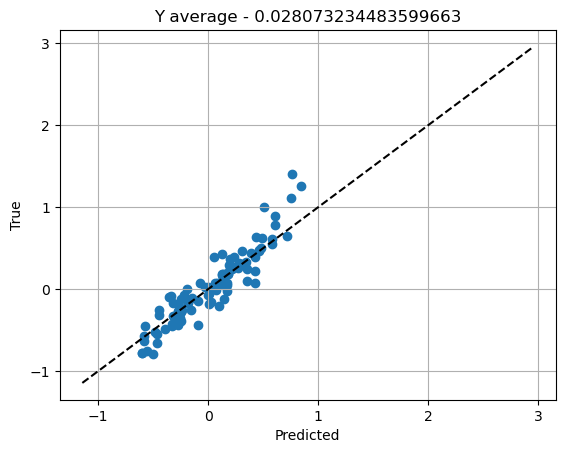

In [15]:
plt.scatter(y_pred.view(N,-1).mean(-1),y_sample_test.mean(-1).cpu())
plt.title(f'Y average - {mean_squared_error(y_pred.view(N,-1).mean(-1),y_sample_test.mean(-1).cpu())}')
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot([y_sample_test.min(),y_sample_test.max()],[y_sample_test.min(),y_sample_test.max()],'k--')
plt.show()

# Test GP_RBF class

In [16]:
class GP_RBF(botorch.models.SingleTaskGP):
    def __init__(self,bounds = (0,1),device = 'cuda'):
        self.device = device
        self.bounds = bounds
    def fit(self,X,Y,use_scipy = True,options:dict = None,**kwargs):
        X = self.normalization(X,self.bounds)
        super().__init__(X,Y,**kwargs)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self).to(self.device)
        if use_scipy:
            botorch.fit.fit_gpytorch_mll(mll)
        else:
            botorch.fit.fit_gpytorch_mll(mll,optimizer=botorch.optim.fit.fit_gpytorch_mll_torch, options=options)
        return self
    def forward(self,x):
        x = self.normalization(x, bounds=self.bounds)
        return super().forward(x)
    def predict(self,x,return_std = False):
        self.eval()
        with torch.no_grad():
            observed_pred = self.posterior(x)
            y_pred = observed_pred.mean.cpu()
            std_pred = observed_pred.mvn.covariance_matrix.diag().sqrt().cpu()
        if return_std: return y_pred,std_pred
        else: return y_pred
        
    @staticmethod
    def normalization(X, bounds):
        return (X - bounds[0]) / (bounds[1] - bounds[0])